In [1]:
import warnings
warnings.filterwarnings('ignore')
import re
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import fetch_20newsgroups, load_files
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from tqdm.auto import tqdm
import json
from fractions import Fraction

In [2]:
# df_orig = pd.read_csv('./data/data.csv')

In [3]:
def contains_digits(s: str):
    """Функция для проверки наличия цифр

    Args:
        s (str): строка

    Returns:
        bool: наличие или отсутствие цифр в строке
    """
    return any(char.isdigit() for char in s)

def code_rare_categories(df, column: str, threshold: float, new_val):
    """кодирование редких категорий как other, используя threshold
    
    Keyword arguments: \n
    df -- dataframe\n
    column -- имя колонки\n
    threshold -- процентный допуск, ниже которого ставится значение other\n
    Return: обновленный df
    """
    
    category_counts = df[column].value_counts()
    total_count = len(df)
    category_percentages = (category_counts / total_count) * 100
    rare_categories = category_percentages[category_percentages < threshold].index
    new_column = column + '_cleaned'
    df[new_column] = df[column].apply(lambda x: new_val if x in rare_categories else x)
    return df

# end def

def replace_based_on_pattern(value, pattern, new_value):
    if re.search(pattern, value):
        return new_value
    return value


def convert_target(cell_val):
    """
    Purpose: 
    """
    pattern = r"\d+(,\d+)?(\.\d+)?"
    
    num_str = re.sub(r'[^0-9.]', '', cell_val)

    # num_str = re.search(pattern, cell_val)

    if (num_str):
        # comment: 
        try:
            # comment: 
            return float(num_str)
        except Exception as e:
            return None
        # end try
        # return float(num_str)
    else:
        return None
        # comment: 
    # end if
# end def

def addr_to_coords(addr, geolocator):
    """
    Purpose: 
    """
    geolocator = Nominatim(user_agent="my_geocoder", scheme='http', domain='localhost:8080', timeout=10)

    # Геокодирование адреса
    try:
        # comment: 
        location = geolocator.geocode(addr)
        if (location):
        # comment:
            return (location.latitude, location.longitude)
        else:
            # comment: 
            return None
    # end if
    except (GeocoderTimedOut, GeocoderUnavailable) as e:
        print(f"Error: {e}. Retrying...")
        time.sleep(2)  # Добавляем задержку перед повторной попыткой
        return addr_to_coords(addr, geolocator)
    # end try

def convert_bath(cell_val):
    """
    Purpose: 
    """
    pattern = r"\d+[,.]?\d*"
    num_str = re.search(pattern, cell_val)

    if (num_str):
        # comment: 
        return float(num_str.group().replace(',' , ''))
    else:
        return None
        # comment: 
    # end if
# end def

def value_percentage(df, column):
    """
    Purpose: процент значений колонки от общего числа строк
    """
    name_series = df[column].value_counts(dropna=False)
    name_df = name_series.to_frame()
    name_df.reset_index(inplace=True)
    name_df['percent'] = name_df['count'] / df.shape[0] * 100
    return name_df

# end def

# Пользовательская функция для объединения столбцов по условию
def combine_columns(row):
    if ((row['private_pool'] + row['privatepool']) < 1):
        return 0
    else:
        return 1
    
def missing_values_per_column(df):
    """
    Purpose: вывод количества отсутствующих значений в датасете
    """
    missing_values = df.isna().sum()
    print("Количество значений NaN по каждой колонке:")
    print(missing_values)

# end def

# Функция для безопасной десериализации JSON-строк
def safe_json_loads(json_str):
    try:
        return json.loads(json_str)
    except (json.JSONDecodeError, TypeError):
        return None
    

# Функция для извлечения данных из 'atAGlanceFacts'
def extract_home_facts(home_facts, label):
    if not home_facts or 'atAGlanceFacts' not in home_facts:
        return None
    for fact in home_facts['atAGlanceFacts']:
        if fact.get('factLabel') == label:
            return fact.get('factValue')
    return None



def quote_replace(cell_val):
    
    def replace(match):
        return f'{match.group(1)}\'{match.group(3)}'

    """
    Purpose: 
    """
    pattern = r'([a-zA-Z])(\")([a-zA-Z])'
    new_text = re.sub(pattern, replace, cell_val)

    return new_text
# end def

def word_in_quote_replace(cell_val):
    
    def replace(match):
        return f'\'{match.group(2)}\''

    """
    Purpose: 
    """
    pattern = r'(\")(\w+)(\")'
    new_text = re.sub(pattern, replace, cell_val)

    return new_text
# end def

def get_school_rating(cell_val):
    """
    Purpose: 
    """
    if (cell_val):
        # comment: 
        rating = cell_val.get('rating')

        if (rating):
            # comment:
            av_rate = []
            for item in rating:
                # comment: 
                try:
                    # comment: 
                    item = float(Fraction(item))
                    av_rate.append(item)
                except Exception as e:
                    item = 0
                    av_rate.append(item)
                # end try
            # end for
            return round(np.mean(av_rate), 2)
        else:
            # comment: 
            return None
        # end if
    else:
        return None
        # comment: 
    # end if    
# end def

def get_schools_qty(cell_val):
    """
    Purpose: 
    """
    if (cell_val):
        # comment: 
        rating = cell_val.get('rating')

        if (rating):
            return len(rating)
        else:
            # comment: 
            return None
        # end if
    else:
        return None
        # comment: 
    # end if    
# end def

def get_avg_school_dist(cell_val):
    """
    Purpose: 
    """
    if (cell_val):
        # comment: 
        rating = cell_val.get('data')

        if (rating):
            # comment:
            dist = rating.get('Distance')
            dist_list = []
            for item in dist:
                # comment: 
                pattern = r"[-+]?\d*[.,]\d+"
                if (re.search(pattern, item)):
                    # comment: 
                    number = re.search(pattern, item).group()
                else:
                    # comment: 
                    number = 0
                # end if
                dist_list.append(float(number))
            # end for
            return round(np.mean(dist_list), 2)
        else:
            # comment: 
            return None
        # end if
    else:
        return None
        # comment: 
    # end if    
# end def



df = df_orig.copy()

df.drop(['zipcode', 'mls-id', 'MlsId'], axis=1, inplace=True)

df['street'] = df['street'].astype(str).str.strip()
df['state'] = df['state'].astype(str).str.strip()
df['full_addr'] = df['street'] +', '+ df['state']

tqdm.pandas(desc="Processing rows")

df100 = df.copy()

df100['coords'] = df100['full_addr'].progress_apply(lambda x: addr_to_coords(x, geolocator))
df100[['latitude', 'longitude']] = df100['coords'].apply(lambda x: pd.Series(x) if x is not None else pd.Series([None, None]))

df100.to_csv('./data/data_with_coords50000.csv', mode='a+', header=False)

In [4]:
df = pd.read_csv('data/data_with_coords50000.csv', index_col=0)
df.columns = map(str.lower, df.columns)
df.columns = df.columns.str.replace(' ', '_')

In [5]:
df.loc[354143]['homefacts']

"{'atAGlanceFacts': [{'factValue': '559990649990', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$454', 'factLabel': 'Price/sqft'}]}"

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 377185 entries, 0 to 377184
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        337267 non-null  object 
 1   private_pool  4181 non-null    object 
 2   propertytype  342452 non-null  object 
 3   street        377183 non-null  object 
 4   baths         270847 non-null  object 
 5   homefacts     377185 non-null  object 
 6   fireplace     103114 non-null  object 
 7   city          377151 non-null  object 
 8   schools       377185 non-null  object 
 9   sqft          336608 non-null  object 
 10  beds          285903 non-null  object 
 11  state         377185 non-null  object 
 12  stories       226469 non-null  object 
 13  privatepool   40311 non-null   object 
 14  target        374704 non-null  object 
 15  full_addr     377185 non-null  object 
 16  coords        264625 non-null  object 
 17  latitude      264625 non-null  float64
 18  longitude

Изменим имена колонок

In [7]:
df = df.rename(columns={
    'propertytype': 'property_type',
    'latitude': 'lat',
    'longitude': 'lon'
})

Удалим колонки, участвовавшие в геокодировании и строки с отсутствующими координатами

In [8]:
df = df.dropna(subset=['coords'])

labels = [
    'street',
    'city',
    'full_addr',
    'coords'
]

df.drop(labels=labels, axis=1, inplace=True)


In [9]:
missing_values_per_column(df)

Количество значений NaN по каждой колонке:
status            25067
private_pool     261609
property_type     20641
baths             71332
homefacts             0
fireplace        177950
schools               0
sqft              27122
beds              58205
state                 0
stories           97523
privatepool      239905
target             2103
lat                   0
lon                   0
dtype: int64


точно можно удалить строки с нулевыми значениями в target, толку от неизвестной цены не будет

In [10]:
df = df.dropna(subset=['target'])

df['target'] = df['target'].astype(str)
df['target'] = df['target'].map(convert_target)

Обработаем столбец 'private_pool'

In [11]:
df.loc[df['private_pool'] == 'Yes', 'private_pool'] = 1
# df['private_pool'].fillna(0, inplace=True)
mask = df['private_pool'].isna()
df.loc[~mask, 'private_pool'] = df.loc[~mask, 'private_pool'].astype(int)
# df['private_pool'] = df['private_pool'].astype('Int64')

Обработаем столбец 'privatepool'

In [12]:
df.loc[df['privatepool'] == 'Yes', 'privatepool'] = 1
df.loc[df['privatepool'] == 'yes', 'privatepool'] = 1
# df['privatepool'].fillna(0, inplace=True)
mask = df['privatepool'].isna()
df.loc[~mask, 'privatepool'] = df.loc[~mask, 'privatepool'].astype(int)
# df['privatepool'] = df['privatepool'].astype(int)

Объединим столбцы 'private_pool' и 'privatepool'

In [13]:
# df['pool'] = df.apply(combine_columns, axis=1)
# df.drop(['private_pool', 'privatepool'], axis=1, inplace=True)

df['pool'] = df['private_pool'].add(df['privatepool'], fill_value=0)
df.drop(['private_pool', 'privatepool'], axis=1, inplace=True)

Приведем статус for sale к единому виду

In [14]:
df.loc[df['status'] == 'For sale', 'status'] = 'for_sale'
df.loc[df['status'] == 'for sale', 'status'] = 'for_sale'

Посмотрим, какие значения есть в колонке status и как они распределяются

In [15]:
status_df = value_percentage(df, 'status')
status_df

,status,count,percent
0,for_sale,139938,53.305247
1,Active,74157,28.247918
2,NaN,24558,9.354645
3,foreclosure,5059,1.927077
4,Pending,3974,1.513778
...,...,...,...
144,Coming soon: Oct 29.,1,0.000381
145,Pending W/Backup Wanted,1,0.000381
146,Pending Backups Wanted,1,0.000381
147,Pending Bring Backup,1,0.000381


Оставим объекты, которые в данный момент активны и продаются

In [16]:
# filtered_status_df = status_df.loc[status_df['percent'] >= 10]
# filtered_status_df

In [17]:
# status_list = filtered_status_df['status'].to_list()
status_list = ['for_sale', 'Active']
df = df.loc[df['status'].isin(status_list)]

In [18]:
# df = df.loc[df['status'].isin(status_list)]

In [19]:
status_df = value_percentage(df, 'status')
status_df

,status,count,percent
0,for_sale,139938,65.362573
1,Active,74157,34.637427


Удалим колонку status, она не нужна, в таблице только активные объекты

In [20]:
df.drop(['status'], axis=1, inplace=True)

Закодируем статус объекта недвижимости

df = pd.get_dummies(df, columns=['status'], dtype=int)

In [21]:
missing_values_per_column(df)

Количество значений NaN по каждой колонке:
property_type     17763
baths             63410
homefacts             0
fireplace        142298
schools               0
sqft              23098
beds              55929
state                 0
stories           86262
target                0
lat                   0
lon                   0
pool             192112
dtype: int64


In [22]:
mask = df['baths'].isna()
df.loc[~mask, 'baths'] = df.loc[~mask, 'baths'].astype(str)
df.loc[~mask, 'baths'] = df.loc[~mask, 'baths'].apply(convert_bath)

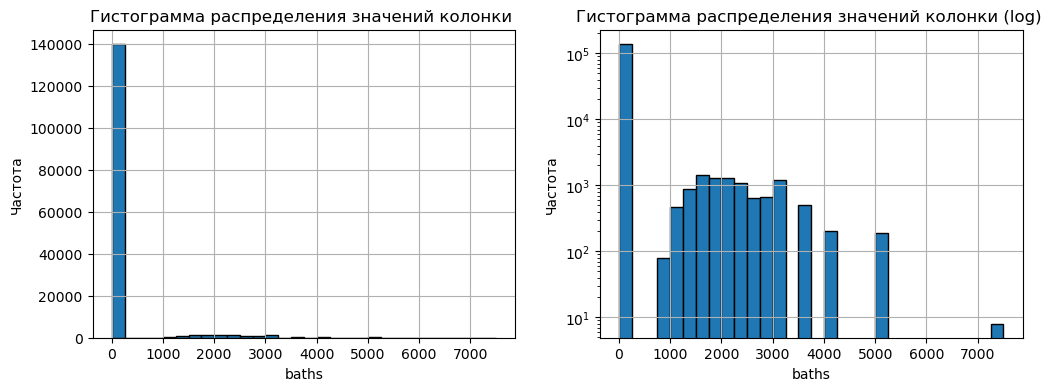

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['baths'], bins=30, edgecolor='black')
plt.title(f'Гистограмма распределения значений колонки ')
plt.xlabel('baths')
plt.ylabel('Частота')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(df['baths'], bins=30, edgecolor='black', log=True)
plt.title(f'Гистограмма распределения значений колонки (log) ')
plt.xlabel('baths')
plt.ylabel('Частота')
plt.grid(True)

plt.show()

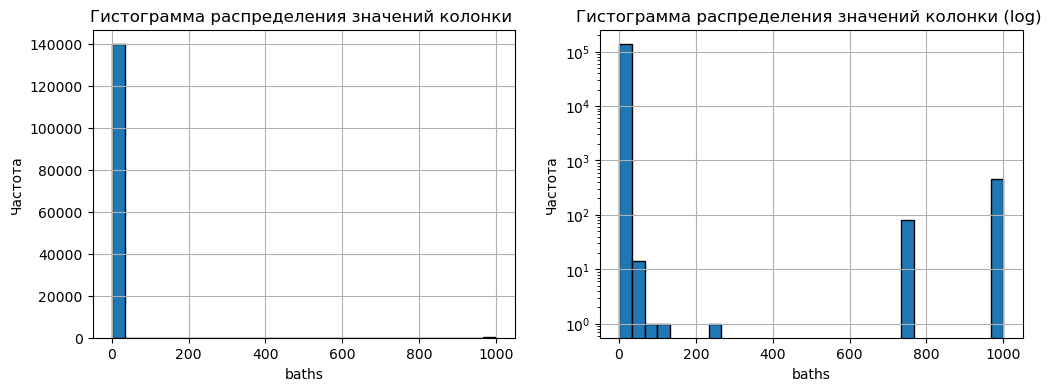

In [24]:
df.loc[df['baths'] > 1000, 'baths'] = np.nan

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['baths'], bins=30, edgecolor='black')
plt.title(f'Гистограмма распределения значений колонки ')
plt.xlabel('baths')
plt.ylabel('Частота')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(df['baths'], bins=30, edgecolor='black', log=True)
plt.title(f'Гистограмма распределения значений колонки (log) ')
plt.xlabel('baths')
plt.ylabel('Частота')
plt.grid(True)

plt.show()

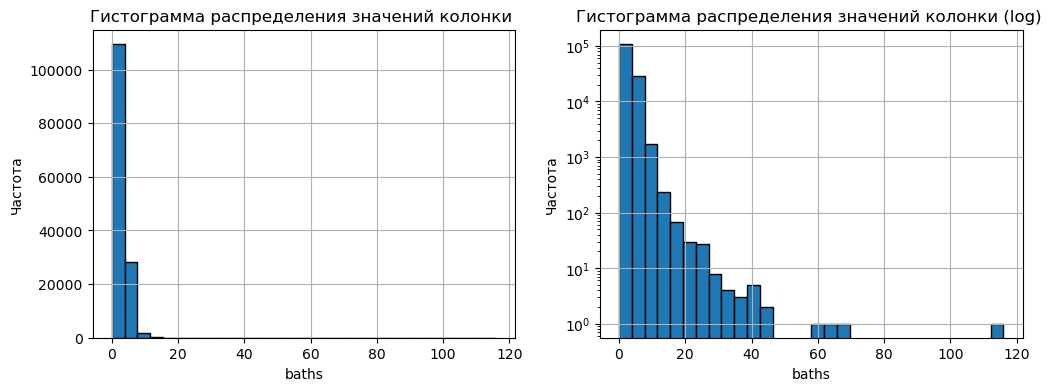

In [25]:
df.loc[df['baths'] > 200, 'baths'] = np.nan

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['baths'], bins=30, edgecolor='black')
plt.title(f'Гистограмма распределения значений колонки ')
plt.xlabel('baths')
plt.ylabel('Частота')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(df['baths'], bins=30, edgecolor='black', log=True)
plt.title(f'Гистограмма распределения значений колонки (log) ')
plt.xlabel('baths')
plt.ylabel('Частота')
plt.grid(True)

plt.show()

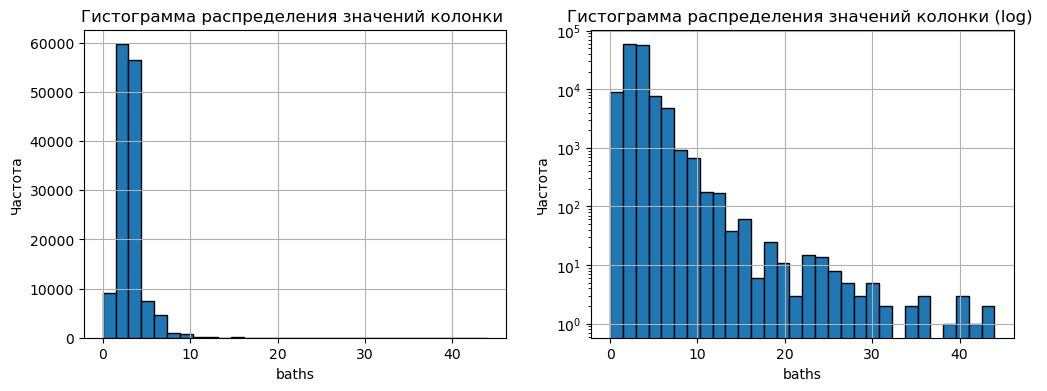

In [26]:
df.loc[df['baths'] > 50, 'baths'] = np.nan

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['baths'], bins=30, edgecolor='black')
plt.title(f'Гистограмма распределения значений колонки ')
plt.xlabel('baths')
plt.ylabel('Частота')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(df['baths'], bins=30, edgecolor='black', log=True)
plt.title(f'Гистограмма распределения значений колонки (log) ')
plt.xlabel('baths')
plt.ylabel('Частота')
plt.grid(True)

plt.show()

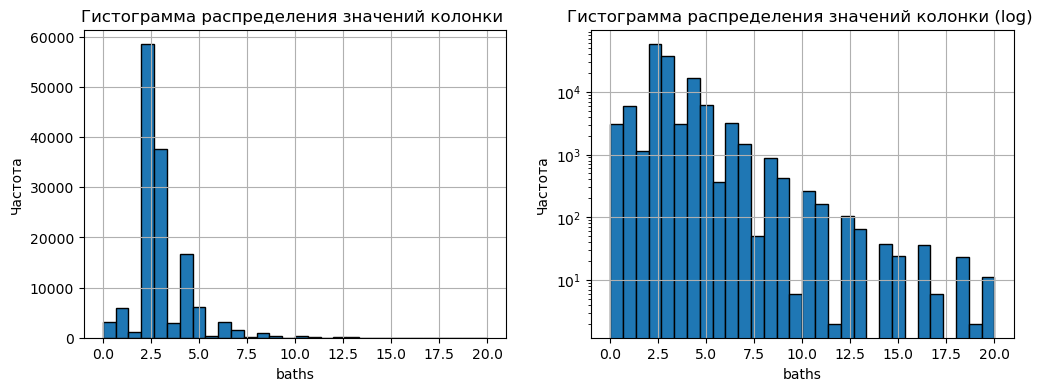

In [27]:
df.loc[df['baths'] > 20, 'baths'] = np.nan

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['baths'], bins=30, edgecolor='black')
plt.title(f'Гистограмма распределения значений колонки ')
plt.xlabel('baths')
plt.ylabel('Частота')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(df['baths'], bins=30, edgecolor='black', log=True)
plt.title(f'Гистограмма распределения значений колонки (log) ')
plt.xlabel('baths')
plt.ylabel('Частота')
plt.grid(True)

plt.show()

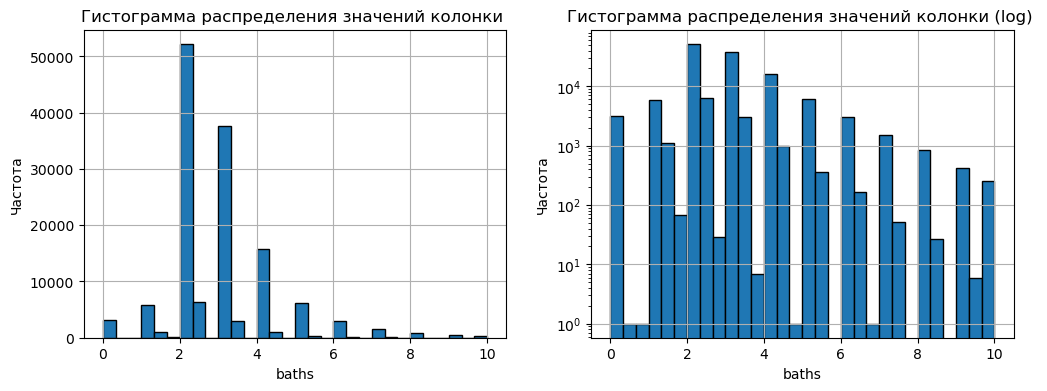

In [28]:
df.loc[df['baths'] > 10, 'baths'] = np.nan

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['baths'], bins=30, edgecolor='black')
plt.title(f'Гистограмма распределения значений колонки ')
plt.xlabel('baths')
plt.ylabel('Частота')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(df['baths'], bins=30, edgecolor='black', log=True)
plt.title(f'Гистограмма распределения значений колонки (log) ')
plt.xlabel('baths')
plt.ylabel('Частота')
plt.grid(True)

plt.show()

In [29]:
df['baths'].info()

<class 'pandas.core.series.Series'>
Index: 214095 entries, 0 to 377182
Series name: baths
Non-Null Count   Dtype 
--------------   ----- 
139118 non-null  object
dtypes: object(1)
memory usage: 3.3+ MB


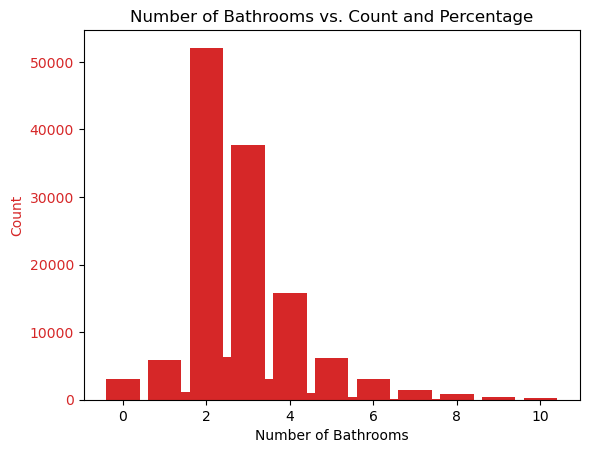

In [30]:
# Данные
baths = value_percentage(df, 'baths')['baths']
counts = value_percentage(df, 'baths')['count']
percent = value_percentage(df, 'baths')['percent']
# Создание графика
fig, ax1 = plt.subplots()

# Первая ось Y (для количества)
color = 'tab:red'
ax1.set_xlabel('Number of Bathrooms')
ax1.set_ylabel('Count', color=color)
ax1.bar(baths, counts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Заголовок и вывод графика
plt.title('Number of Bathrooms vs. Count and Percentage')
plt.show()

In [31]:
# code_rare_categories(df=df, column='baths', threshold=0.02, new_val=0)
# df['baths_cleaned'] = df['baths_cleaned'].fillna(0)

In [32]:
# _df = value_percentage(df=df, column='baths_cleaned')
# _df.to_csv('./data/baths.csv')

In [33]:
# df['baths_cleaned']

In [34]:
df['property_type'] = df['property_type'].str.lower()
df['property_type'] = df['property_type'].astype(str)

In [35]:
pattern = r'single.*family'  # Шаблон для поиска
new_value = 'single_family'  # Новое значение для замены

df['property_type'] = df['property_type'].apply(replace_based_on_pattern, args=(pattern, new_value))


In [36]:
pattern = r'mult.*family'  # Шаблон для поиска
new_value = 'multi_family'  # Новое значение для замены

df['property_type'] = df['property_type'].apply(replace_based_on_pattern, args=(pattern, new_value))


In [37]:
pattern = r'land'  # Шаблон для поиска
new_value = 'land'  # Новое значение для замены

df['property_type'] = df['property_type'].apply(replace_based_on_pattern, args=(pattern, new_value))

In [38]:
pattern = r'condo'  # Шаблон для поиска
new_value = 'condo'  # Новое значение для замены

df['property_type'] = df['property_type'].apply(replace_based_on_pattern, args=(pattern, new_value))

In [39]:
pattern = r'ranch'  # Шаблон для поиска
new_value = 'ranch'  # Новое значение для замены

df['property_type'] = df['property_type'].apply(replace_based_on_pattern, args=(pattern, new_value))

In [40]:
pattern = r'nan'  # Шаблон для поиска
new_value = 'other'  # Новое значение для замены

df['property_type'] = df['property_type'].apply(replace_based_on_pattern, args=(pattern, new_value))

In [41]:
pattern = r'detached'  # Шаблон для поиска
new_value = 'single_family'  # Новое значение для замены

df['property_type'] = df['property_type'].apply(replace_based_on_pattern, args=(pattern, new_value))

Обработаем категории с целью уменьшения списка

Найдем редкие категории и назовем их other

In [42]:
df = code_rare_categories(df=df, column='property_type', threshold=1, new_val='other')
df.drop(labels=['property_type'], axis=1, inplace=True)
df = df.rename(columns={
    'property_type_cleaned': 'property_type'
})

In [43]:
_df = value_percentage(df, 'property_type')
_df.head(50)

,property_type,count,percent
0,single_family,127949,59.762722
1,other,31075,14.514585
2,land,24249,11.326280
3,multi_family,9390,4.385903
4,townhouse,8853,4.135080
5,condo,5028,2.348490
6,traditional,4817,2.249936
7,ranch,2734,1.277003


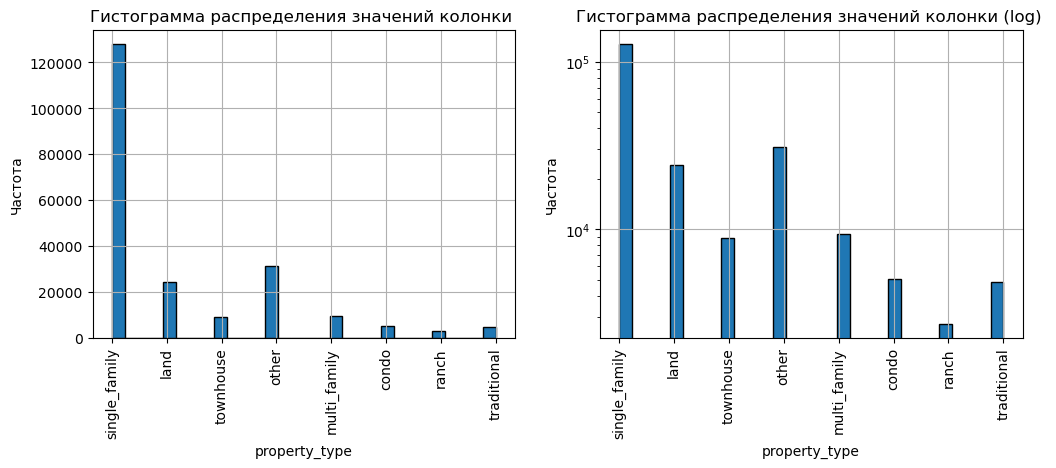

In [44]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['property_type'], bins=30, edgecolor='black')
plt.title(f'Гистограмма распределения значений колонки ')
plt.xlabel('property_type')
plt.xticks(rotation=90)
plt.ylabel('Частота')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(df['property_type'], bins=30, edgecolor='black', log=True)
plt.title(f'Гистограмма распределения значений колонки (log) ')
plt.xlabel('property_type')
plt.xticks(rotation=90)
plt.ylabel('Частота')
plt.grid(True)

plt.show()

In [45]:
df = pd.get_dummies(df, columns=['property_type'], dtype=int)

In [46]:
# df['fireplace'] = df['fireplace'].fillna(0)
mask = df['fireplace'].isna()
df.loc[~mask, 'fireplace'] = df.loc[~mask, 'fireplace'].astype(str)

# code_rare_categories(df=df, column='fireplace', threshold=0.1, new_val='other')

In [47]:
value_percentage(df, 'fireplace')

,fireplace,count,percent
0,NaN,142298,66.464887
1,yes,40413,18.876200
2,Yes,10787,5.038418
3,1,10368,4.842710
4,2,1873,0.874845
...,...,...,...
1276,"Den, Kitchen",1,0.000467
1277,"Extra Closets, In-Law Quarters",1,0.000467
1278,"2 Fireplaces, Decorative Fireplace, Family Roo...",1,0.000467
1279,"Gas, Gas Starters",1,0.000467


Больше половины данных о камине отсутствует, смысла в колонке нет.

In [48]:
df.drop('fireplace', axis=1, inplace=True)

In [49]:
df.sample(5, random_state=48)

,baths,homefacts,schools,sqft,beds,state,stories,target,lat,lon,pool,property_type_condo,property_type_land,property_type_multi_family,property_type_other,property_type_ranch,property_type_single_family,property_type_townhouse,property_type_traditional
347530,2.0,"{'atAGlanceFacts': [{'factValue': '1973', 'fac...","[{'rating': ['3', '3', '1', '2', '2', 'NR', 'N...",1591,3.0,TN,1.00,225000.0,36.053767,-86.674700,NaN,0,0,0,0,0,1,0,0
281121,3.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...","[{'rating': ['4/10', 'None/10', '9/10', '6/10'...","1,740 sqft",3 Beds,OR,2.0,333900.0,45.391952,-122.609684,NaN,1,0,0,0,0,0,0,0
130895,2.0,"{'atAGlanceFacts': [{'factValue': '1988', 'fac...","[{'rating': ['9/10', '6/10', '8/10', '9/10'], ...","1,803 sqft",3 Beds,TX,1.0,205000.0,29.578067,-95.378902,NaN,0,0,0,0,0,1,0,0
106801,NaN,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...","[{'rating': ['1', 'NR', '3', '4', '4'], 'data'...","1,531",Baths,AZ,NaN,219500.0,33.491844,-112.244938,NaN,0,0,0,0,1,0,0,0
166646,3.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...","[{'rating': ['5/10', '4/10'], 'data': {'Distan...","2,566 sqft",3 Beds,TX,NaN,224855.0,31.680224,-106.254632,NaN,0,0,0,0,0,1,0,0


Обработаем колонку sqft

In [50]:
mask = df['sqft'].isna()
df.loc[~mask, 'sqft'] = df.loc[~mask, 'sqft'].astype(str)

df.loc[~mask, 'sqft'] = df.loc[~mask, 'sqft'].apply(convert_target)

Обработаем колонку states

In [51]:
df_states = pd.read_csv('./data/states.csv', header=None, names=['State', 'Code'])
state_to_code = df_states.set_index('State')['Code'].to_dict()

df['state_code'] = df['state'].map(state_to_code)
df.drop(labels=['state'], axis=1, inplace=True)
df = df.rename(columns={
    'state_code': 'state'
})

Обработаем колонку beds

In [52]:
df['beds'] = df['beds'].fillna(-1)
df['beds'] = df['beds'].astype(str)
df['beds'] = df['beds'].apply(lambda x: x if contains_digits(x) else '0')
df['beds'] = df['beds'].str.replace(r'[^0-9.]+', '', regex=True)
df['beds'] = pd.to_numeric(df['beds'], errors='coerce')
df['beds'] = df['beds'].fillna(0)
df['beds'] = df['beds'].astype(int)
df['beds'] = np.where(df['beds'] > 5, 0, df['beds'])

df.loc[df['baths'] == -1, 'baths'] = np.nan

Обработаем колонку homefacts

In [53]:
df['homefacts'] = df['homefacts'].str.replace('\'', '\"')
df['homefacts'] = df['homefacts'].map(quote_replace)
df['homefacts'] = df['homefacts'].str.replace('\"factValue": None', '"factValue": "None"')

# Десериализация JSON-полей
df['homefacts_deserialized'] = df['homefacts'].apply(safe_json_loads)
df['glance'] = df['homefacts_deserialized'].apply(lambda x: x['atAGlanceFacts'] if x is not None else None)

df['year_built'] = df['homefacts_deserialized'].apply(lambda x: extract_home_facts(x, 'Year built'))
df['remodeled_year'] = df['homefacts_deserialized'].apply(lambda x: extract_home_facts(x, 'Remodeled year'))
df['heating'] = df['homefacts_deserialized'].apply(lambda x: extract_home_facts(x, 'Heating'))
df['cooling'] = df['homefacts_deserialized'].apply(lambda x: extract_home_facts(x, 'Cooling'))
df['parking'] = df['homefacts_deserialized'].apply(lambda x: extract_home_facts(x, 'Parking'))
df['lot_size'] = df['homefacts_deserialized'].apply(lambda x: extract_home_facts(x, 'lotsize'))
df['price_per_sqft'] = df['homefacts_deserialized'].apply(lambda x: extract_home_facts(x, 'Price/sqft'))

df.drop(['homefacts', 'homefacts_deserialized', 'glance'], axis=1, inplace=True)


Обработаем колонку schools

In [54]:
df['schools'] = df['schools'].str.replace('\'', '\"')
df['schools'] = df['schools'].map(quote_replace)
df['schools_deserialized'] = df['schools'].apply(safe_json_loads)
df['schools_deserialized'] = df['schools_deserialized'].map(lambda x: x[0] if x else None)

df['avg_school_rating'] = df['schools_deserialized'].map(get_school_rating)
df['avg_school_rating'] = df['avg_school_rating'].fillna(-1)

df['schools_qty'] = df['schools_deserialized'].map(get_schools_qty)
df['schools_qty'] = df['schools_qty'].fillna(-1)
df['schools_qty'] = df['schools_qty'].astype(int)

df['avg_school_dist'] = df['schools_deserialized'].map(get_avg_school_dist)
df['avg_school_dist'] = df['avg_school_dist'].fillna(-1)

df.drop(['schools', 'schools_deserialized'], axis=1, inplace=True)

df.loc[df['avg_school_rating'] == -1, 'avg_school_rating'] = np.nan
df.loc[df['schools_qty'] == -1, 'schools_qty'] = np.nan
df.loc[df['avg_school_dist'] == -1, 'avg_school_dist'] = np.nan

In [55]:
df.to_csv('data/df_cleaned.csv')

In [56]:
_df = value_percentage(df=df, column='stories')
_df.head(15)


,stories,count,percent
0,NaN,86262,40.291459
1,1.0,40989,19.145239
2,2.0,34304,16.022794
3,1,11874,5.546136
4,2,10723,5.008524
5,3.0,5982,2.794087
6,0.0,3928,1.834700
7,One,3778,1.764637
8,3,2207,1.030851
9,Two,1931,0.901936


Почти 40% записей не имеет данных об этажности объекта, колонка stories полезной не будет

In [57]:
df.drop('stories', axis=1, inplace=True)

In [58]:
df.head()

,baths,sqft,beds,target,lat,lon,pool,property_type_condo,property_type_land,property_type_multi_family,...,year_built,remodeled_year,heating,cooling,parking,lot_size,price_per_sqft,avg_school_rating,schools_qty,avg_school_dist
0,3.5,2900.0,4,418000.0,35.627887,-77.335173,NaN,0,0,0,...,2019,,"Central A/C, Heat Pump",,,None,$144,3.25,8.0,5.54
1,3.0,1947.0,3,310000.0,47.699482,-117.190979,NaN,0,0,0,...,2019,,,,,5828 sqft,$159/sqft,0.27,3.0,1.33
2,2.0,3000.0,3,2895000.0,33.943243,-117.376310,1,0,0,0,...,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,0.67,3.0,1.96
3,8.0,6457.0,5,2395000.0,32.702323,-97.347071,NaN,0,0,0,...,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft,0.92,4.0,0.75
4,NaN,NaN,1,5000.0,27.041567,-82.136146,NaN,0,1,0,...,,,,,,"10,019 sqft",None,0.47,3.0,4.08


In [59]:
value_percentage(df, 'remodeled_year')

,remodeled_year,count,percent
0,,115954,54.160069
1,None,5599,2.615194
2,2006,2753,1.285878
3,2005,2746,1.282608
4,2007,2095,0.978538
...,...,...,...
148,1800,1,0.000467
149,1869,1,0.000467
150,1897,1,0.000467
151,1874,1,0.000467


In [60]:
df['remodeled_year'] = df['remodeled_year'].apply(lambda x: x if x != '' else 0)
df['year_built'] = df['year_built'].apply(lambda x: x if x != '' else 0)

df['remodeled_year'] = df['remodeled_year'].apply(lambda x: 0 if ((x == 'None') or (x == 'No Data')) else x)
df['year_built'] = df['year_built'].apply(lambda x: 0 if ((x == 'None') or (x == 'No Data')) else x)

df['remodeled_year'] = df['remodeled_year'].astype(int)
df['year_built'] = df['year_built'].astype(int)

df['year_built'] = df['year_built'].apply(lambda x: x if x <=2024 else np.nan)

In [61]:
_df = value_percentage(df=df, column='parking')
_df.head(20)

,parking,count,percent
0,,102546,47.897429
1,Attached Garage,48451,22.630608
2,2 spaces,11107,5.187884
3,Detached Garage,9738,4.548448
4,1 space,4735,2.211635
5,Carport,4478,2.091595
6,No Data,2314,1.080829
7,3 spaces,2286,1.067750
8,Off Street,2234,1.043462
9,"Carport, Attached Garage",2160,1.008898


In [62]:
_df = value_percentage(df=df, column='heating')
_df.head(20)

,heating,count,percent
0,,60335,28.181415
1,Forced Air,56511,26.395292
2,Forced air,22401,10.463112
3,Other,17422,8.137509
4,Gas,5612,2.621266
5,Electric,5211,2.433966
6,Central Electric,4918,2.297111
7,Heat Pump,4332,2.023401
8,Central,4055,1.894019
9,Central Air,3389,1.582942


In [63]:
_df = value_percentage(df=df, column='cooling')
_df.head(20)

,cooling,count,percent
0,Central,89076,41.605829
1,,70896,33.114272
2,Central Air,8896,4.155165
3,None,5639,2.633877
4,Has Cooling,4668,2.180341
5,Central Electric,3543,1.654873
6,Central Gas,2955,1.380228
7,Wall,2167,1.012167
8,No Data,1898,0.886522
9,Central Heating,1677,0.783297


In [64]:
df.drop(['parking', 'heating', 'cooling', 'lot_size'], axis=1, inplace=True)

In [65]:
df['price_per_sqft'] = df['price_per_sqft'].map(convert_target)
df['price_per_sqft'] = df['price_per_sqft'].fillna(np.nan)
df['price_per_sqft'] = df['price_per_sqft'].astype(float)

In [66]:
missing_values_per_column(df)

Количество значений NaN по каждой колонке:
baths                           74977
sqft                            23265
beds                                0
target                              0
lat                                 0
lon                                 0
pool                           192112
property_type_condo                 0
property_type_land                  0
property_type_multi_family          0
property_type_other                 0
property_type_ranch                 0
property_type_single_family         0
property_type_townhouse             0
property_type_traditional           0
state                               0
year_built                          2
remodeled_year                      0
price_per_sqft                  64855
avg_school_rating                4174
schools_qty                      4174
avg_school_dist                  4214
dtype: int64


In [67]:
col = df.pop('target')

# Вставляем его в конец
df.insert(len(df.columns), 'target', col)

In [68]:
df.to_csv('./data/df_for_ML_new.csv')

In [69]:
df[df['year_built'] == 559990649990]

,baths,sqft,beds,lat,lon,pool,property_type_condo,property_type_land,property_type_multi_family,property_type_other,...,property_type_townhouse,property_type_traditional,state,year_built,remodeled_year,price_per_sqft,avg_school_rating,schools_qty,avg_school_dist,target


In [70]:
df.describe()

,beds,lat,lon,property_type_condo,property_type_land,property_type_multi_family,property_type_other,property_type_ranch,property_type_single_family,property_type_townhouse,property_type_traditional,state,year_built,remodeled_year,price_per_sqft,avg_school_rating,schools_qty,avg_school_dist,target
count,214095.000000,214095.000000,214095.000000,214095.000000,214095.000000,214095.000000,214095.000000,214095.000000,214095.000000,214095.000000,214095.000000,214095.000000,214093.000000,214095.000000,1.492400e+05,209921.000000,209921.000000,209881.000000,2.140950e+05
mean,2.468278,33.910743,-90.848755,0.023485,0.113263,0.043859,0.145146,0.012770,0.597627,0.041351,0.022499,29.419828,1634.256898,854.106541,5.028792e+02,1.801822,4.479033,2.573284,6.348003e+05
std,1.476706,5.695202,13.921520,0.151438,0.316915,0.204782,0.352249,0.112281,0.490377,0.199101,0.148301,16.798852,746.350743,980.944268,2.380016e+04,2.092680,5.087469,3.750999,1.866929e+06
min,0.000000,24.551935,-124.185180,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,1.000000e+00
25%,1.000000,29.551192,-97.166672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,1923.000000,0.000000,1.150000e+02,0.400000,3.000000,1.020000,1.800000e+05
50%,3.000000,33.144925,-84.428538,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,36.000000,1966.000000,0.000000,1.630000e+02,0.630000,3.000000,1.720000,3.165000e+05
75%,4.000000,38.865028,-80.862458,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,48.000000,2001.000000,1979.000000,2.620000e+02,3.000000,5.000000,3.110000,5.850000e+05
max,5.000000,49.008838,-67.093135,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,55.000000,2022.000000,2020.000000,5.950000e+06,10.000000,65.000000,1187.510000,1.950000e+08
